In [0]:
sc

Out[1]:

SparkContext 

 Spark UI 

 
 Version 
 v3.1.0 
 Master 
 local[8] 
 AppName 
 Databricks Shell

## Zadanie: 

1. połączyć się z dowolnym zbiorem danych, czy to offline excel file, czy online data przez API, 
2. przetworzyć te dane 
3. wyświetlić wizualizację np. średniej / mediany zarobków w zależności od obszaru zamieszkania / płci / poziomu wykształcenia 
   wystarczy jedno z tych (albo własna inwencja twórcza - od koloru do wyboru). 

Ważne, żeby pokazać jakieś np. SQL query, przetwarzanie dataframe i proste operacje na dataframe oraz wizualzację. Należy użyć SQL, pandas i np. matplotlib albo PySpark z Azure (preferowane).

In [0]:
path_adult = "/databricks-datasets/adult/adult.data"

field_names = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education-num",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
    "native-country",
    "label"
]

df_adult = spark.read.csv(path_adult)
df_adult = df_adult.toDF(*field_names)
df_adult.registerTempTable("adult")

In [0]:
df_adult.count() == df_adult.na.drop().count()
# spawdzamy czy występują wartości null, zbiory sa równe - nie występują

Out[5]: True

In [0]:
df_adult.drop_duplicates().count()
# spawdzamy duplikaty 
df_adult = df_adult.drop_duplicates()
# usuwa duplikaty 


In [0]:
# usuwamy spacje w kolumnach, które występują w całym zbiorze adult 
from pyspark.sql import functions as f

for colname in df_adult.columns:
    df_adult = df_adult.withColumn(colname, f.trim(f.col(colname)))

# 1. Pandas way


W odniesieniu do zawartości zbioru adult, który pokazuje zarobki w kolumnie label jako powyżej 50 i ponizej 50 k, 
bedzie to średnia, mediana wieku w odniesieniu do poziomu zarobków

In [0]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
df_pandas = df_adult.toPandas()
df_pandas.head(3)

Out[11]:

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,44,Local-gov,181344,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,Black,Male,0,0,38,United-States,>50K
1,20,?,137300,HS-grad,9,Never-married,?,Other-relative,White,Female,0,0,35,United-States,<=50K
2,26,Private,90980,Assoc-voc,11,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,55,United-States,<=50K


In [0]:
df_pandas.agg(['mean', 'median'])

Out[12]:

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
mean,inf,inf,inf,inf,inf,inf
median,37.0,178356.0,10.0,0.0,0.0,40.0


zbiór danych jest duży, pandas pokazuje inf jako srednią, wyjsciem jest wykoanie obliczenia tablicą numpy i wstawienie w df

In [0]:
np.asarray(df_pandas.age, dtype=np.float).mean()

Out[13]: 38.585548759873376

In [0]:
df_pandas['age'] = pd.DataFrame(np.asarray(df_pandas.age, dtype=np.float))
df_pandas.age.agg(['mean', 'median'])

Out[16]: mean 38.585549
median 37.000000
Name: age, dtype: float64

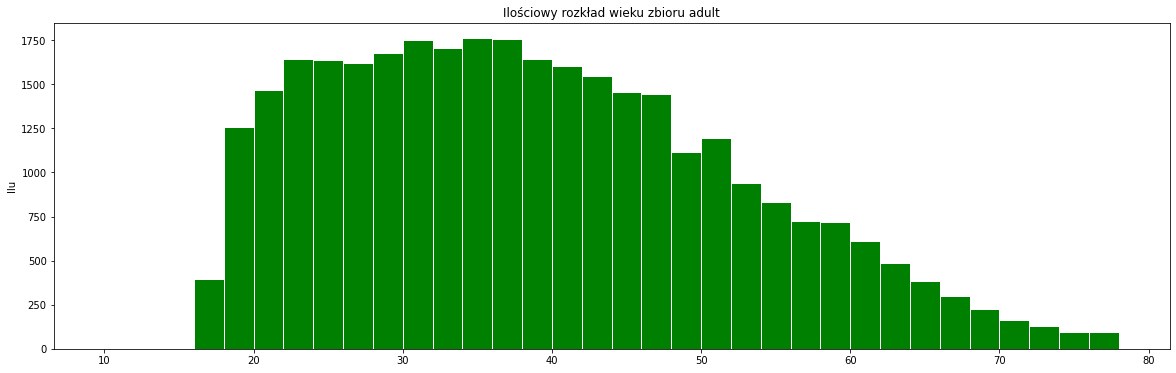

In [0]:
wiek = df_pandas.sort_values(by='age',ascending=True)  
plt.figure(figsize=(20,6))
plt.title ('Ilościowy rozkład wieku zbioru adult')
plt.ylabel('Ilu')
plt.hist(wiek.age, bins = np.arange(10,80,2), color='green', edgecolor = 'white');


Out[19]:

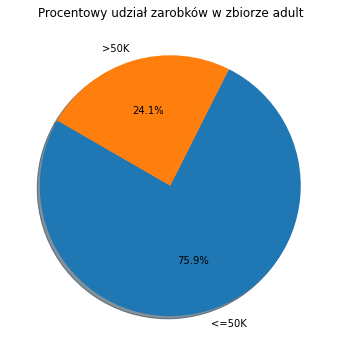

([<matplotlib.patches.Wedge at 0x7f698630a790>,
 <matplotlib.patches.Wedge at 0x7f698630ae80>],
 [Text(0.3148710844914664, -1.053971631568501, '<=50K'),
 Text(-0.3148710351514925, 1.0539716463086792, '>50K')],
 [Text(0.17174786426807256, -0.5748936172191823, '75.9%'),
 Text(-0.17174783735535953, 0.5748936252592796, '24.1%')])

In [0]:
label = df_pandas['label'].value_counts()
plt.figure(figsize=(12,6))
plt.title ('Procentowy udział zarobków w zbiorze adult')
plt.pie(label,labels= label.index, autopct='%1.1f%%',startangle=150,shadow=True)

Out[20]:

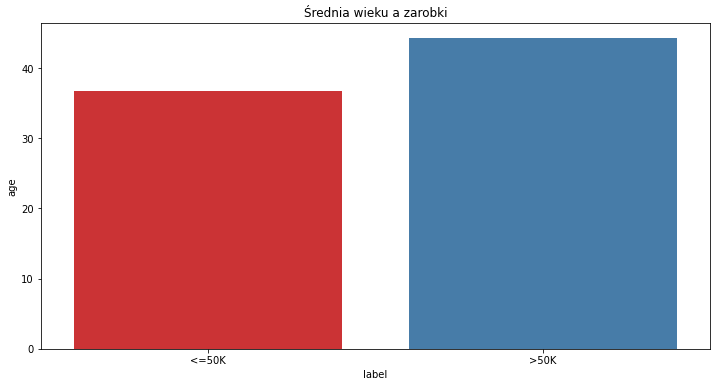

<matplotlib.axes._subplots.AxesSubplot at 0x7f6984039e20>

In [0]:
labels = df_pandas.groupby('label')['age'].mean()
plt.figure(figsize=(12,6))
plt.title ('Średnia wieku a zarobki')
sns.barplot(x=labels.index, y= labels, palette='Set1')

In [0]:
labels

Out[21]: label
<=50K 36.787392
>50K 44.250925
Name: age, dtype: float64

Out[22]:

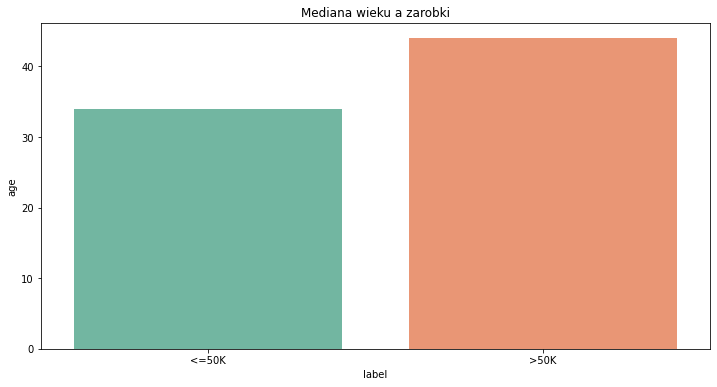

<matplotlib.axes._subplots.AxesSubplot at 0x7f6982c62880>

In [0]:
labelm = df_pandas.groupby('label')['age'].median()
plt.figure(figsize=(12,6))
plt.title ('Mediana wieku a zarobki')
sns.barplot(x=labelm.index, y= labelm, palette='Set2')

In [0]:
labelm


Out[23]: label
<=50K 34.0
>50K 44.0
Name: age, dtype: float64

## SQL way

średnia wieku dla danej klasy pracowniczej

In [0]:
# w zbiorze workclass, pojawia się grupa oznaczona znakiem zapytania, pomińmy ją 


In [0]:

%sql
SELECT count(*), round(avg(age), 0) as avg_age, workclass FROM adult
where workclass != ' ?' group by workclass
ORDER BY avg_age ASC;   

count(1),avg_age,workclass
7,21.0,Never-worked
22696,37.0,Private
1298,39.0,State-gov
2093,42.0,Local-gov
960,43.0,Federal-gov
2541,45.0,Self-emp-not-inc
1116,46.0,Self-emp-inc
14,48.0,Without-pay


wpływ rasy i płci na zamożność

In [0]:
%sql 
SELECT race, sex, label, count(*) as count FROM adult GROUP BY race, sex, label;

race,sex,label,count
Asian-Pac-Islander,Male,<=50K,460
Black,Male,<=50K,1272
Other,Male,>50K,19
Amer-Indian-Eskimo,Male,<=50K,168
White,Female,<=50K,7614
White,Male,<=50K,13085
Black,Male,>50K,297
Other,Male,<=50K,143
Black,Female,<=50K,1465
Asian-Pac-Islander,Female,>50K,43


Drogą przez SQL, nie udało mi się wyświetlić mediany, dowiedziałem się, że nie jest naturalną funkcją SQL-a

## Pyspark display way 

średni wiek i mediana w odniesieniu do rasy

In [0]:
import pyspark.sql.functions as func    
mediana = df_adult.groupBy('race').agg(func.percentile_approx("age", 0.5).alias("median age"))
display(mediana)

race,median age
Other,31.0
Amer-Indian-Eskimo,35.0
White,37.0
Asian-Pac-Islander,36.0
Black,36.0


In [0]:
srednia = df_adult.groupBy('race').agg(func.mean(df_adult['age']).alias("average age"))
display(srednia)

race,average age
Other,33.457564575645755
Amer-Indian-Eskimo,37.17363344051447
White,38.77542723511423
Asian-Pac-Islander,37.69653179190752
Black,37.77642536835362


In [0]:
df_adult.agg({"age": "stddev"}).show()

+------------------+
 stddev(age)|
+------------------+
13.637983518469737|
+------------------+